In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import evofr as ef
from evofr.plotting import *
import string


# TODO: Move data files to repo
# TODO: Move data processing to another notebook
raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_nextstrain_clades_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})
raw_cases =  pd.read_csv("../../HHMI_poster/data/case_counts_usa.tsv.gz", sep="\t")

In [9]:
# Trying USAFacts cases
# Load the data from the CSV file
raw_cases = pd.read_csv("../data/covid_confirmed_usafacts.csv")

# Melt the DataFrame from wide to long format
raw_cases = raw_cases.drop(columns=["StateFIPS", "countyFIPS"])
raw_cases = pd.melt(raw_cases, id_vars=["County Name", "State"], 
                    var_name="date", value_name="cases")

# Group by 'State' and 'date', then sum the 'cases'
raw_cases = raw_cases.groupby(['State', 'date'])['cases'].sum().reset_index()

# Convert 'date' to datetime format
raw_cases['date'] = pd.to_datetime(raw_cases['date'])

# Sort by 'State' and 'date'
raw_cases.sort_values(by=['State', 'date'], inplace=True)

# Calculate the difference between consecutive days for each state
raw_cases['cases'] = raw_cases.groupby('State')['cases'].diff().fillna(0).clip(0, None).astype(int)

# Rename 'State' to 'location'
raw_cases.rename(columns={'State': 'location'}, inplace=True)

# Select and reorder columns to match the required format
raw_cases = raw_cases[['date', 'location', 'cases']]

state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

raw_cases["location"] = raw_cases["location"].map(state_abbrev_to_name)

In [10]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils

In [11]:
date_start = "2021-01-01"
date_end = "2022-11-01"
def filter_dates(df, date_start, date_end):
    _df = df[df.date < date_end]
    _df = _df[_df.date > date_start].copy()
    return _df

raw_seq = filter_dates(raw_seq, date_start, date_end)
raw_cases = filter_dates(raw_cases, date_start, date_end) # Cases stop in 2022?

In [12]:
print(len(raw_seq.variant.unique()))

36


In [13]:
# Need to merge in ons data
raw_cases_ons = pd.read_csv("../../rt-from-frequency-dynamics/data/uk-ons/prepared_cases_ons.tsv", sep="\t")
raw_cases_ons["location"] = "England"
raw_seq_ons = pd.read_csv("../../rt-from-frequency-dynamics/data/uk-ons/uk-ons-variant-sequence-counts.tsv", sep="\t")

raw_seq_ons = filter_dates(raw_seq_ons, date_start, date_end)
raw_cases_ons = filter_dates(raw_cases_ons, date_start, date_end) # Cases stop in 2022?

# Combine. data sets
raw_cases = pd.concat((raw_cases, raw_cases_ons))
raw_seq = pd.concat((raw_seq, raw_seq_ons))

In [14]:
#locations = pd.unique(raw_seq["location"])
#locations = ["Nevada", "Texas", "Tennessee", "Oregon", "Pennsylvania", "Wisconsin", "Minnesota", "Massachusetts", "California", "Florida", "Michigan", "Illinois", "Ohio", "New York", "Georgia", "Virginia", "Washington"]
#locations += ["England"]

excluded = ["American Samoa", 
            'Puerto Rico', 
            'Virgin Islands', 
            'Washington DC', 
            'Northern Mariana Islands',
            'Guam',
            'USA',
            "Stockton"]

def parse_data_by_location(raw_seq, raw_cases, locations=None, excluded=None):
    if locations is None:
        locations = pd.unique(raw_seq["location"])
        
    if excluded is not None:
        locations = [loc for loc in locations if loc not in excluded]
    
    # Create data by location
    data = {}
    cases = {}
    for loc in locations:
        _raw_seq = raw_seq[raw_seq.location == loc].copy()
        _raw_cases = raw_cases[raw_cases.location == loc].copy()
        if len(_raw_seq) > 0:
            data[loc] = ef.VariantFrequencies(_raw_seq, pivot="20I")
            cases[loc] = _raw_cases
    return data, cases, locations

data, cases, locations = parse_data_by_location(raw_seq, raw_cases, excluded = excluded)

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/evofr/data/data_helpers.py:90: UserWarning: 20I not present in variant names. Using provided order.
  warnings.warn(f"{pivot} not present in variant names. Using provided order.")


In [15]:
from relative_fitness_hsgp import RelativeFitnessHSGP, SquaredExponential, Matern
import numpyro.distributions as dist

hsgp_mat = Matern(
    L=1000, 
    num_basis=250,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(0.1),
    nu=5/2)

hsgp = SquaredExponential(
    L=750, 
    num_basis=250,
    rho = 1000, # dist.HalfNormal(0.01),
    alpha = 0.1 # dist.HalfNormal(1.0)
)

fitness_model = RelativeFitnessHSGP(hsgp)
#inference_method = ef.InferNUTS(num_samples=500, num_warmup=500)
inference_method = ef.InferMAP(iters=50_000, lr=4e-4)
#inference_method = ef.InferFullRank(iters=50_000, lr=4e-4, num_samples=500)

In [16]:
infer = False
load = True

num_locations = len(locations)

In [17]:
# Fit models for all remaining locations
posteriors = {}
if infer:
    for i, loc in enumerate(locations): # Could use tqdm
        print(f"Fitting to {loc} ({i+1}/{num_locations})")
        posteriors[loc] = inference_method.fit(fitness_model, data=data[loc]) 
        posteriors[loc].save_posterior(f"../data/posteriors/selective-pressure-analysis/{loc}.pkl")

In [18]:
posteriors = {}
if load:
    for i, loc in enumerate(locations): # Could use tqdm
        posteriors[loc] = ef.PosteriorHandler(data=data[loc], name=loc)
        posteriors[loc].load_posterior(f"../data/posteriors/selective-pressure-analysis/{loc}.pkl")

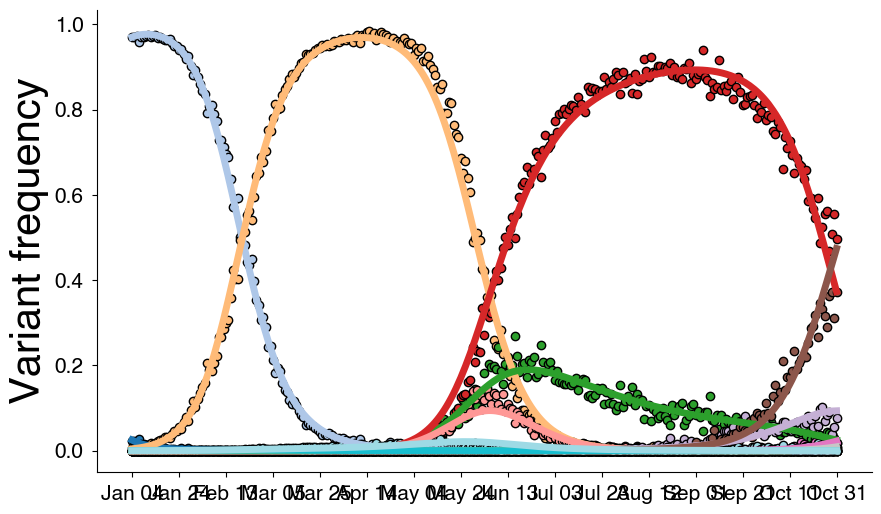

In [19]:
from evofr.plotting import FrequencyPlot
FrequencyPlot(posteriors["England"]).plot()

In [20]:
def compute_selective_pressure(posterior):
    delta = posterior.samples["delta"]
    num_samples, T, _ = delta.shape
    delta = jnp.concatenate((delta, jnp.zeros((num_samples,T,1))), axis=-1)
    freq = posterior.samples["freq"]        
        
    # Mean fitness
    delta_bar = (delta * freq).sum(axis=-1)
    
    # Mean square deviation
    delta_sse = jnp.square(delta - delta_bar[..., None])
    selective_pressure_var = (delta_sse * freq).sum(axis=-1)
    
    # Change in relative fitness overall
    selective_pressure_expect = (jnp.diff(delta, axis=-2, prepend=jnp.nan) * freq).sum(axis=-1)
    selective_pressure = selective_pressure_var + selective_pressure_expect
    
    return delta_bar.T, selective_pressure.T

In [21]:
delta_bar, selective_pressure = compute_selective_pressure(posteriors["England"])
#plt.plot(delta_bar)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marlinfiggins/Documents/relative-fitness-mechanisms/notebooks/figures/selective_pressure_cases_Alabama.png'

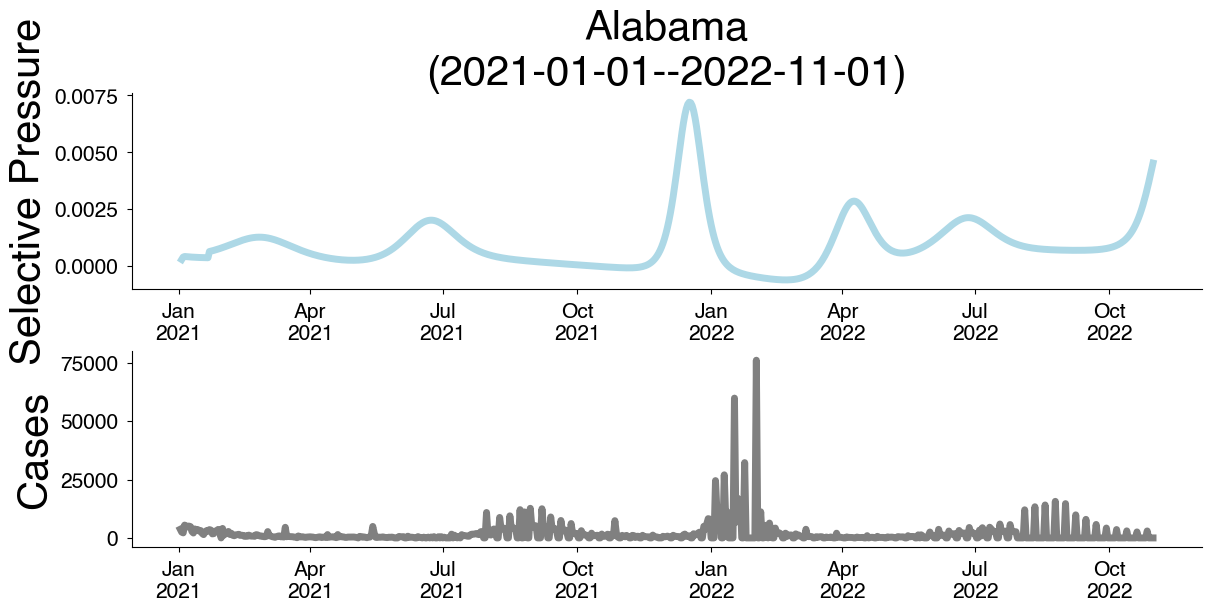

In [22]:
import matplotlib.dates as mdates

def plot_selective_pressure_cases(loc):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    t = np.arange(len(selective_pressure))
    ax0.plot(data[loc].dates, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax0.set_title(loc + f"\n({date_start}--{date_end})")

    # Plot cases
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    #t_cases = [t for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    ax1.plot(pd.to_datetime(cases[loc].date.values), cases[loc].cases, color="gray")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax1.set_ylabel("Cases")
    return fig

fig_selective_pressure_cases = {}
for loc in locations:
    fig_selective_pressure_cases[loc] = plot_selective_pressure_cases(loc)
    fig_selective_pressure_cases[loc].savefig(f"figures/selective_pressure_cases_{loc}.png")
fig_selective_pressure_cases

# Michigan data looks maybe inconsistent wtih state dashboard 

In [ ]:
def plot_selective_pressure_growth(loc, window_n):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    # Prep data
    t_cases = [t for t in pd.to_datetime(cases[loc].date.values)]
    #_, smooth_cases = fit_spline(cases, data, loc, n_knots=42, degree=4)
    #empirical_growth = np.diff(np.log(smooth_cases))

    smooth_cases = cases[loc].cases.rolling(window=window_n, min_periods=window_n).mean()
    empirical_growth = np.log(smooth_cases / smooth_cases.shift(1)).rolling(window=window_n, min_periods=1).mean()    

    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    t = np.arange(len(selective_pressure))
    ax0.plot(data[loc].dates, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    ax0.set_title(loc + f"\n({date_start}--{date_end})")
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    # Plot empirical growth rates
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    #ax1.plot(t_cases, cases[loc].cases.values, color="gray")
    #ax1.plot(t_cases, smooth_cases, color="red")
    ax1.plot(t_cases, empirical_growth, color="gray")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax1.set_ylabel("Empirical Growth Rate")
    return fig

window_n = 14
fig_selective_pressure_growth = {}
for loc in locations:
    fig_selective_pressure_growth[loc] = plot_selective_pressure_growth(loc, window_n)
    fig_selective_pressure_growth[loc].savefig(f"figures/selective_pressure_growth_{loc}.png")
fig_selective_pressure_growth

In [23]:
def make_dataframes(loc, window_n):
    # Create selective pressure column for each date
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    selective_pressure_df = pd.DataFrame({"selective_pressure": selective_pressure[:,-1], "date": data[loc].dates})
    
    # Create smooth cases and empirical growth dataframe
    t_cases = [t for t in pd.to_datetime(cases[loc].date.values)]
    #smooth_cases = cases[loc].cases.rolling(window=7, min_periods=1).mean().values
    #empirical_growth = np.diff(np.log(smooth_cases), prepend=np.nan)
    #empirical_growth_change = np.diff(empirical_growth, prepend=np.nan)
    smooth_cases = cases[loc].cases.rolling(window=window_n, min_periods=1).mean()
    empirical_growth = np.log(smooth_cases / smooth_cases.shift(1)).rolling(window=window_n, min_periods=1).mean()
    empirical_growth_change = empirical_growth.diff()
    
    growth_df = pd.DataFrame({"date": t_cases, 
                              "cases": cases[loc].cases,
                              "smooth_cases": smooth_cases, 
                              "empirical_growth_rate": empirical_growth,
                              "empirical_growth_change": empirical_growth_change
                             })
    # Merge on date
    selective_pressure_df = selective_pressure_df.merge(growth_df, on="date", how="left")
    selective_pressure_df["location"] = loc
    return selective_pressure_df

selective_pressure_dfs = {}
for loc in locations:
    selective_pressure_dfs[loc] = make_dataframes(loc, window_n=14)

selective_pressure_dfs["Washington"]

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
 

selective_pressure       date   cases  smooth_cases  \
0                   NaN 2021-01-02     0.0      0.000000   
1              0.001356 2021-01-03  8496.0   4248.000000   
2              0.001268 2021-01-04  1185.0   3227.000000   
3              0.001236 2021-01-05  2330.0   3002.750000   
4              0.001181 2021-01-06  5234.0   3449.000000   
..                  ...        ...     ...           ...   
663            0.001170 2022-10-27     0.0    646.142857   
664            0.001280 2022-10-28   177.0    531.714286   
665            0.001396 2022-10-29     0.0    531.714286   
666            0.001516 2022-10-30     0.0    531.714286   
667            0.001646 2022-10-31  3131.0    663.428571   

     empirical_growth_rate  empirical_growth_change    location  
0                      NaN                      NaN  Washington  
1                      NaN                      NaN  Washington  
2                -0.274895                      NaN  Washington  
3                -0.173460             1.014355e-01  Washington  
4                -0.069455             1.040052e-01  Washington  
..                     ...                      ...         ...  
663              -0.022244             6.938894e-18  Washington  
664              -0.030743            -8.499453e-03  Washington  
665              -0.030743             0.000000e+00  Washington  
666              -0.030743             0.000000e+00  Washington  
667              -0.006718             2.402501e-02  Washington  

[668 rows x 7 columns]

In [24]:
def save_input_dfs(selective_pressure_dfs):
    df = pd.concat([df_loc for df_loc in selective_pressure_dfs.values()])
    df.to_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t", index=False)
    return None
save_input_dfs(selective_pressure_dfs) # Can now load this file instead of running models again

In [25]:
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}


In [95]:
regions = {
    "Northeast": [
        "Connecticut", "Maine", "Massachusetts", "New Hampshire", "New Jersey", 
        "New York", "Pennsylvania", "Rhode Island", "Vermont"
    ],
    "Midwest": [
        "Illinois", "Indiana", "Iowa", "Kansas", "Michigan", "Minnesota", 
        "Missouri", "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"
    ],
    "South": [
        "Alabama", "Arkansas",  "Florida", "Georgia", "Kentucky", "Louisiana", "Mississippi", "Oklahoma", 
        "South Carolina", "Tennessee", "Texas", 
    ],
    "East":[
        "Delaware", "Maryland", "North Carolina", "Virginia", "West Virginia"
    ],
    "West": [
        "Alaska", "Arizona", "California", "Colorado", "Hawaii", "Idaho", "Montana", 
        "Nevada", "New Mexico", "Oregon", "Utah", "Washington", "Wyoming"
    ]
}

groups = {
    "group_1": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California",
        "Colorado", "Connecticut", "Delaware", "Florida", "Georgia"
    ],
    "group_2": [
        "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland"
    ],
    "group_3": [
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri",
        "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey"
    ],
    "group_4": [
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
        "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina"
    ],
    "group_5": [
        "South Dakota", "Tennessee", "Texas", "Utah", "Vermont",
        "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ]
}

In [116]:
color_map = dict([
    ('19A', '#FF5733'),  # Bright Orange
    ('19B', '#FF33B5'),  # Hot Pink
    ('20A', '#777777'),  # Grey
    ('20B', '#33FF57'),  # Green X
    ('20C', '#3357FF'),  # Bright Blue
    ('20D', '#33FFD1'),  # Light Cyan
    ('20E', '#777777'),  # Grey
    ('20G', '#FF33A5'),  # Pink X
    ('20I', '#33FFF3'),  # Cyan
    ('20J', '#FFBD33'),  # Amber
    ('21A', '#7D33FF'),  # Purple
    ('21C', '#33FFBD'),  # Mint Green
    ('21D', '#777777'),  #'
    ('21B', '#777777'),  #
    ('21E', '#777777'),  #
    ('21F', '#FF335E'),  # Red
    ('21G', '#57FF33'),  # Lime Green
    ('21H', '#FF33D1'),  # Magenta
    ('21I', '#33D1FF'),  # Sky Blue
    ('21J', '#A5FF33'),  # Yellow-Green X
    ('21K', '#FF3333'),  # Bright Red
    ('21L', '#FF8333'),  # Coral
    ('22A', '#33FF83'),  # Sea Green
    ('22B', '#8333FF'),  # Deep Purple
    ('22C', '#33A5FF'),  # Light Blue
    ('22D', '#FFD133'),  # Golden Yellow
    ('22E', '#FF5733'),  # Orange
    ('recombinant', '#3383FF'),  # Cerulean
    ('20H', '#5733FF'),  # Indigo
    ('22F', '#FF3383'),  # Pink-Red
    ('21M', '#33FFD1'),  # Teal
    ('23A', '#FF33A5'),  # Pinkish Red
    ('23B', '#33FF57'),  # Bright Green
    ('23C', '#5733FF'),  # Dark Purple
    ('23D', '#FF3357'),  # Bright Red-Pink
    ('23I', '#FF5733'),  # Darker Orange
    ('other', '#777777')  # Grey
])

# Overwriting color_map for main variants

primary_vars = ["20B", "20C", "20I",    "21J", "21K", "21L", "22A", "22B", "22C",  "22E"]
rarer_vars = [ "20G", "20J", "21A", '21C', "21I",]

color_ramp = ["#A76BB1", "#8FBDD0", "#658447", "#EBA85F", "#D6C568", "#8E1616", "#A0CCA5", "#2A4786", "#926224", "#76104B"]
grey_scale_ramp =  ["#333333", "#4D4D4D", "#666666", "#808080", "#B3B3B3", "#D9D9D9"]
for i, v in enumerate(primary_vars):
    color_map[v] = color_ramp[i]

for i, v in enumerate(rarer_vars):
    color_map[v] = grey_scale_ramp[i]



In [117]:
len(primary_vars)

10

In [118]:
import pickle
with open("../data/posteriors/selective-pressure-analysis/color_map.pkl", 'wb') as f:
    pickle.dump(color_map, f)

In [119]:
import pickle
with open("../data/posteriors/selective-pressure-analysis/example_data.pkl", 'wb') as f:
    pickle.dump(data["Washington"], f)

In [120]:
clade_display_names = {
    "19A": "19A",
    "19B": "19B",
    "20A": "20A",
    "20B": "20B",
    "20C": "20C",
    "20D": "20D",
    "20E": "20E",
    "20F": "20F",
    "20G": "20G",
    "20I": "20I (Alpha)",
    "20H": "20H (Beta)",
    "20J": "20J (Gamma)",
    "21A": "21A (Delta)",
    "21B": "21B (Kappa)",
    "21C": "21C (Epsilon)",
    "21D": "21D (Eta)",
    "21E": "21E (Theta)",
    "21F": "21F (Iota)",
    "21G": "21G (Lambda)",
    "21I": "21I (Delta)",
    "21H": "21H (Mu)",
    "21J": "21J (Delta)",
    "21K": "21K (BA.1)",
    "21L": "21L (BA.2)",
    "21M": "21M (Omicron)",
    "22A": "22A (BA.4)",
    "22B": "22B (BA.5)",
    "22C": "22C (BA.2.12.1)",
    "22D": "22D (BA.2.75)",
    "22E": "22E (BQ.1)",
    "22F": "22F (XBB)",
    "23A": "23A (XBB.1.5)",
    "23B": "23B (XBB.1.16)",
    "23C": "23C (CH.1.1)",
    "23D": "23D (XBB.1.9)",
    "23E": "23E (XBB.2.3)",
    "23F": "23F (EG.5.1)",
    "23G": "23G (XBB.1.5.70)",
    "23H": "23H (HK.3)",
    "23I": "23I (BA.2.86)",
    "24A": "24A (JN.1)",
    "24B": "24B (JN.1.11.1)",
    "24C": "24C (KP.3)",
    "24D": "24D (XDV.1)",
    "24E": "24E (KP.3.1.1)",
    "24F": "24F (XEC)",
    "24G": "24G (KP.2.3)"
}

In [121]:
from evofr.plotting import plot_posterior_time

def plot_model_results(locations, height_per_panel=2.3, width_per_panel=6, freq_thres=0.01):
    num_locations = len(locations)
    
    #legend_vars = ["20B", "20C", "20G", "20I", "20J", "21A", "21I", "21J", "21K", "21L", "22A", "22B", "22C", "22E"]
    legend_vars = primary_vars + rarer_vars
    fig = plt.figure(figsize=(3 * width_per_panel, height_per_panel * num_locations), constrained_layout=True)
    spec = fig.add_gridspec(ncols=3, nrows=num_locations)

    for i, loc in enumerate(locations):
        post = posteriors[loc]

        # Compute selective pressure
        delta_bar, selective_pressure = compute_selective_pressure(post)
        # Prep data
        t_cases = [t for t in pd.to_datetime(cases[loc].date.values)]
        dates = posteriors[loc].data.dates
        var_names = post.data.var_names
        var_idxs = [var_names.index(v) for v in legend_vars if v in var_names]
        raw_freq = post.data.seq_counts /  post.data.seq_counts.sum(axis=-1)[:, None]
 
        # Plot frequency
        ax0 = fig.add_subplot(spec[i, 0])
        #FrequencyPlot(posterior=post, color_map=color_map).plot(ax=ax0)
        for var_idx in var_idxs:
            variant = var_names[var_idx]
            # Skip pivot
            if var_idx == len(var_names) - 1:
                continue
            ax0.plot(np.array(post.data.dates), post.samples["freq"][0, :, var_idx], color=color_map[variant])
            ax0.scatter(np.array(post.data.dates), raw_freq[:, var_idx], color=color_map[variant], ec="k")

        #ax0.set_xticks(ax0.get_xticks()[::4])
        #ax0.set_xticklabels([dates[xtick].strftime('%b\n%Y') for xtick in ax0.get_xticks()])
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        ax0.set_ylabel("Frequency", fontsize=24)
    
        # Plot relative fitness
        ax1 = fig.add_subplot(spec[i, 1])
        for var_idx in var_idxs:
            variant = var_names[var_idx]
            # Skip pivot
            if var_idx == len(var_names) - 1:
                continue
            included = np.array((post.samples["freq"][0, :, var_idx] > freq_thres))
            ax1.plot(np.array(post.data.dates)[included], post.samples["delta"][0, :, var_idx][included], color=color_map[variant])
                
        ax1.axhline(0.0, linewidth=1.0, linestyle="--", color="k")
        #ax1.set_xticks([dates[xtick] for xtick in ax0.get_xticks()])
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        ax1.set_ylabel("Relative\n fitness to 20I", fontsize=24)
        ax1.set_title(loc)
        ax1.set_ylim((-0.2, 0.6))

        # Plot selective pressure
        ax2 = fig.add_subplot(spec[i, 2])
        t = np.arange(len(selective_pressure))
        ax2.plot(data[loc].dates, selective_pressure, color="lightblue")
        ax2.set_ylabel("Selective\n Pressure", fontsize=24)
        #ax2.set_xticks([dates[xtick] for xtick in ax0.get_xticks()])
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        ax2.set_ylim((0., 0.006))
        
        if i == 0:
            # Add legend for focal variants
            variant_color_elements =  [Patch(facecolor=color_map[v], edgecolor='k', label=clade_display_names[v]) for v in sorted(legend_vars)]
            legend_elements = variant_color_elements
            fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5,1.03), fancybox=True, shadow=True, ncol=10, fontsize=12)
    return fig


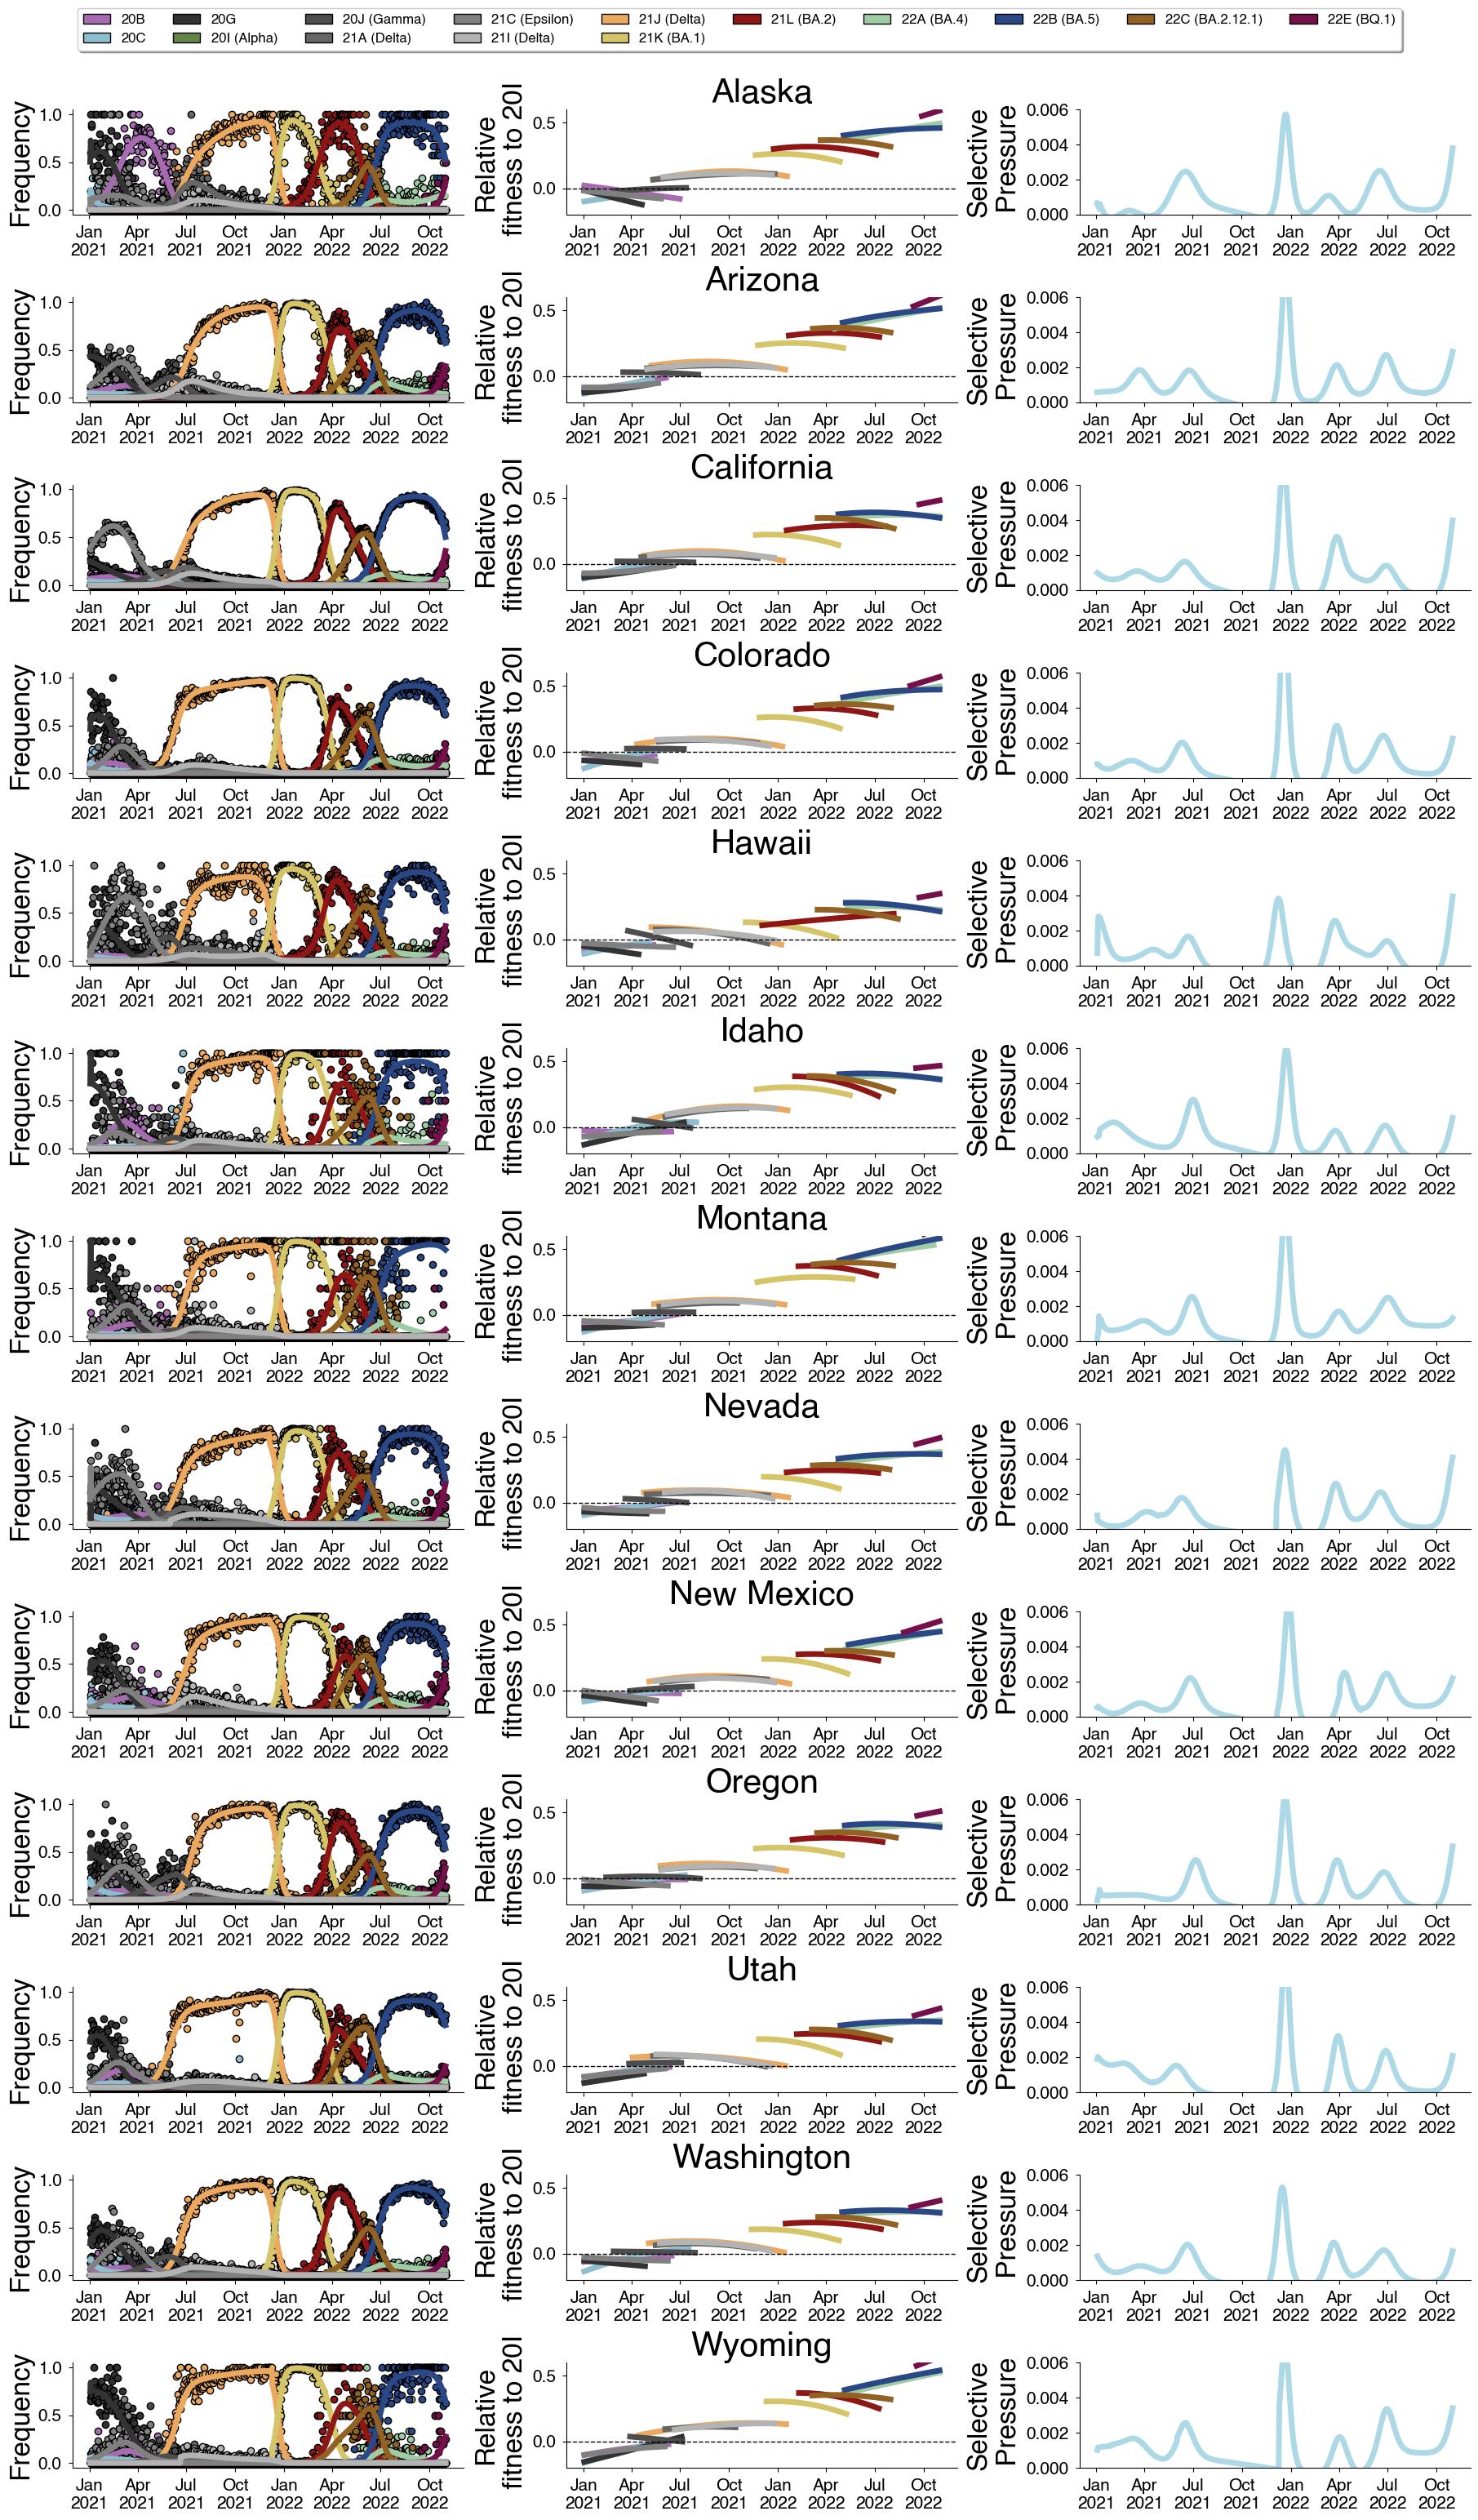

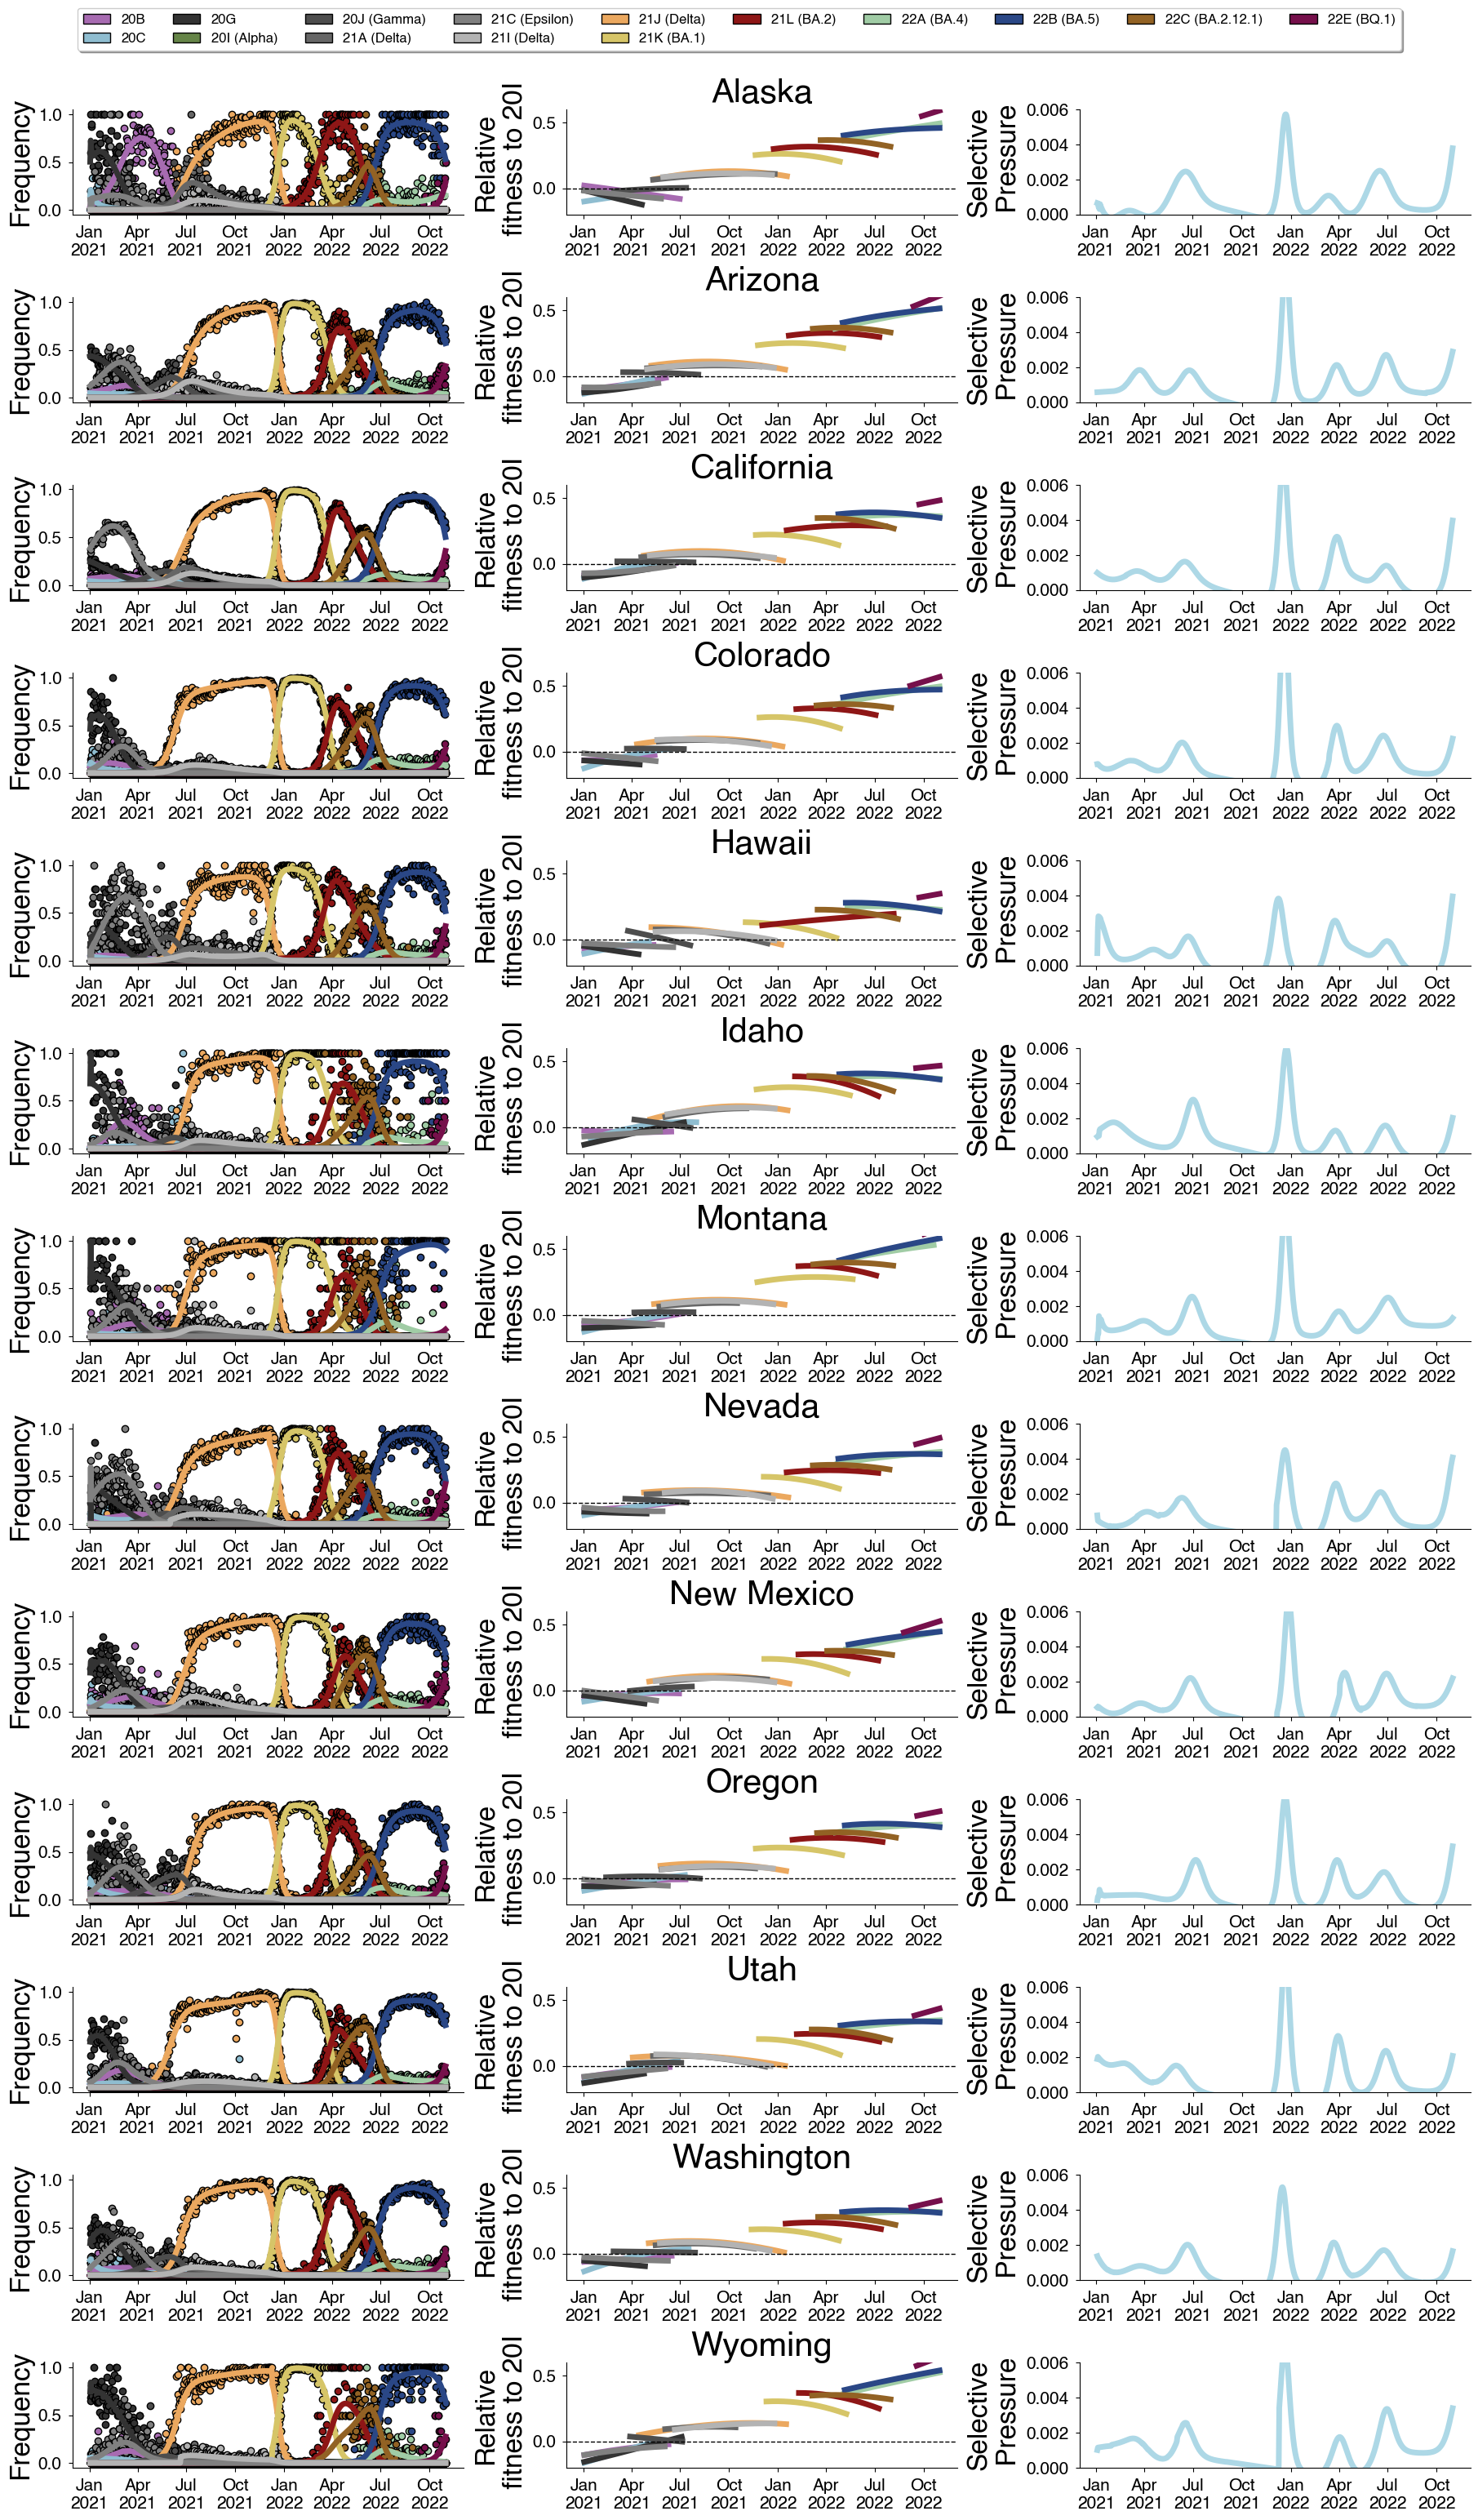

In [122]:
plot_model_results(regions["West"])

In [ ]:
for region_name, locs in groups.items():
    fig_region = plot_model_results(locs)
    fig_region.savefig(f"../manuscript/supplementary_figures/selective-pressure-analysis_{region_name}.png")